# 1. 绪论

In [1]:
# preparation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


from prml.preprocess import PolynomialFeature
from prml.linear import (
    LinearRegression,
    RidgeRegression,
    BayesianRegression
)

np.random.seed(1234)

## 1.1. Example: Polynomial Curve Fitting

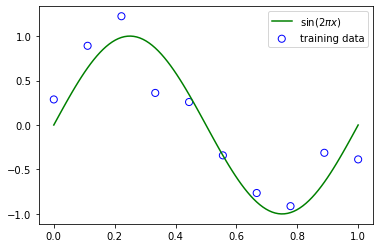

In [5]:
# sample data
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

多项式拟合：<p>
    $y(x,w)=w_0+w_1x+w_2x^2+...+w_Mx^M=\sum_{j=0}^M {w_jx^j} \tag{1.1}$ 

误差函数<p>
$E(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \boldsymbol{w}\right)-t_{n}\right\}^{2} \tag{1.2}$<p>
目标是让误差函数越来越小。有唯一解$w^*$,是的$E(w)$取得最小值$E(w^*)$。

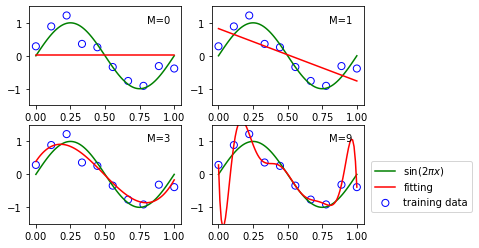

In [7]:
# 几个多项式拟合
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeature(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(0.8, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=0, borderaxespad=0.)
plt.show()

m太大发生过拟合，泛化性能下降。需要一个衡量模型泛化能力的标准。

为了比较不同大小的数据集和保证和t有相同单位。引入均方根误差：<p>
    $E_{R M S}=\sqrt{2 E\left(\boldsymbol{w}^{*}\right) / N} \tag{1.3}$

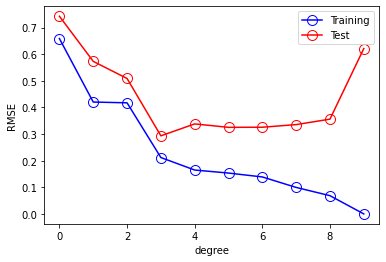

In [8]:
# 均方根对比
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(10):
    feature = PolynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()

解决过拟合的方式：<p>
1. 增加样本个数<p>

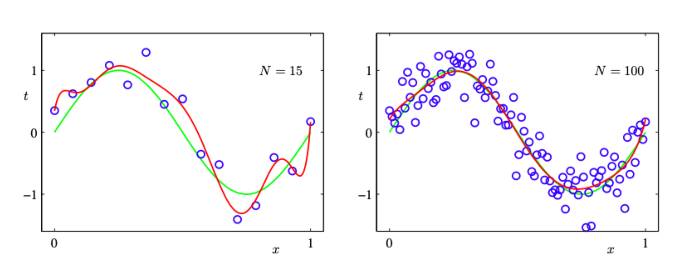

In [9]:
# 样本个数影响
fig, ax = plt.subplots(figsize=(12, 12))
d = plt.imread('./graph/1.1数据增加.png')
plt.axis('off')
ax.imshow(d)

2. 正则化
$\tilde{E}(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \boldsymbol{w}\right)-t_{n}\right\}^{2}+\frac{\lambda}{2}\|\boldsymbol{w}\|^{2} \tag{1.4}$
$\|\boldsymbol{w}\|^{2}\equiv=\boldsymbol{w}_0^2+\boldsymbol{w}_1^2+...+\boldsymbol{w}_M^2$，$\lambda$的大小控制的正则化影响的大小

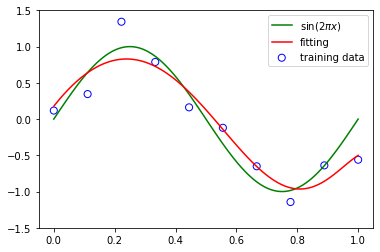

In [10]:
# M=9但用了正则化
feature = PolynomialFeature(9)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = RidgeRegression(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

y = model.predict(X_test)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y, c="r", label="fitting")
plt.ylim(-1.5, 1.5)
plt.legend()
plt.annotate("M=9", xy=(-0.15, 1))
plt.show()

# 1.2 概率论

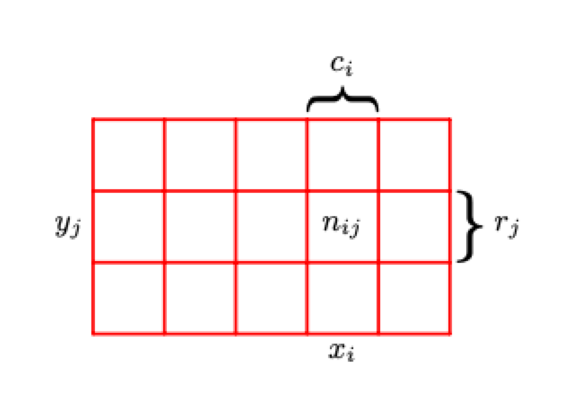

In [20]:
# 样本空间
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2空间.png')
plt.axis('off')
ax.imshow(d)

这里有两个随机变量，X和Y.（离散变量，相互独立）图中简化为{$x_1,x_2,x_3,x_4,x_5$}和{$y_1,y_2,y_3$}。N次取样，每次得到一组的x,y。$X=x_{i}, Y=y_{i}$的取到次数是$n_{ij}$。于是我们有

$p\left(X=x_{i}, Y=y_{i}\right)=\frac{n_{i j}}{N} \tag{1.5}$ <p>
$p\left(X=x_{i}\right)=\frac{c_{i}}{N} \tag{1.6}$<p>

我们可以得到：<p>
$p\left(X=x_{i}\right)=\sum_{j=1}^{L}p\left(X=x_{i}, Y=y_{i}\right) \tag{1.7}$
这就是加法规则。$p\left(X=x_{i}\right)$被叫做边缘概率：因为它通过把其他变量(本例中的Y )边缘化或者加和得到。

条件概率：<p>
$p\left(Y=y_{j} | X=x_{i}\right)=\frac{n_{i j}}{c_i} \tag{1.8}$
    

$p\left(X=x_{i}, Y=y_{j}\right)=\frac{n_{i j}}{N}=\frac{n_{i j}}{c_{i}} \cdot \frac{c_{i}}{N}=p\left(Y=y_{j} | X=x_{i}\right) p\left(X=x_{i}\right) \tag{1.9}$
这就是乘积规则。

sum rule $p(X)=\sum_{Y}p(X,Y) \tag{1.10}$ <p>
product rule $p(X,Y)=P(Y|X)p(X) \tag{1.11}$

根据这两个式子得到本书最重要的定义：贝叶斯定理。<p>
$P(Y | X)=\frac{P(X | Y) P(Y)}{P(X)} \tag{1.12}$

分子中的$P(x)=\sum_{Y}P\left(X | Y\right)P\left(Y\right)$其实这就是加法规则。也确保了概率在归一化之后的值为1.

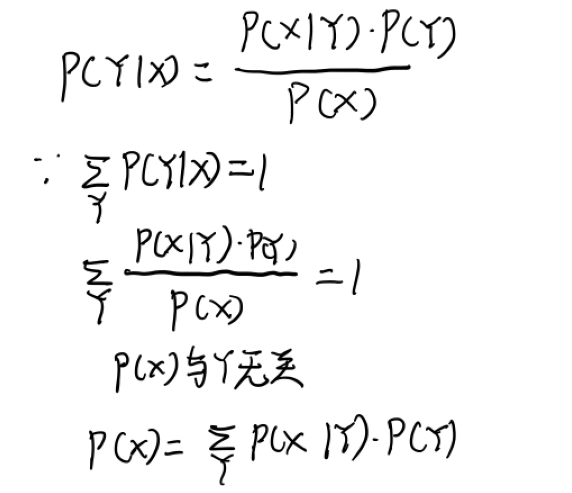

In [19]:
# 样本个数影响
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2归一化.png')
plt.axis('off')
ax.imshow(d)

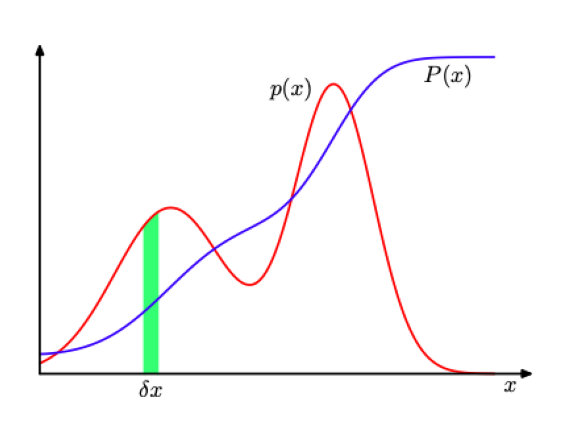

In [23]:
# 累计密度分布
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2累计概率.png')
plt.axis('off')
ax.imshow(d)

## 积分就是连续情况下的相加

## 1.2.1 概率密度  
如果一个实值变量$x$落在区间$(x, x + \delta x)$的概率由$p(x)\delta x$给出，其中$ \delta x \to 0 $，那么我们就把$ p(x) $称作$ x $的概率密度（probability density）。<p>
连续概率分布：<p>
    $p(x \in(a, b))=\int_{a}^{b} p(x) \mathrm{d}x \tag{1.24}$<p>

满足：<p>
    $p(x)\geq0 \tag{1.25}$ <p>
    $\int_{-\infty}^{\infty} p(x) \mathrm{d}x=1 \tag{1.26}$

可以用过Jacobian因子变化：例如:$x=g(y)$<p>
    $p_{y}(y)=p_{x}(x)\left|\frac{\mathrm{d} x}{\mathrm{d} y}\right|=p_{x}(g(y))\left|g^{\prime}(y)\right| \tag{1.27}$ <p>
    概率密度最大值的概念取决于变量的选择

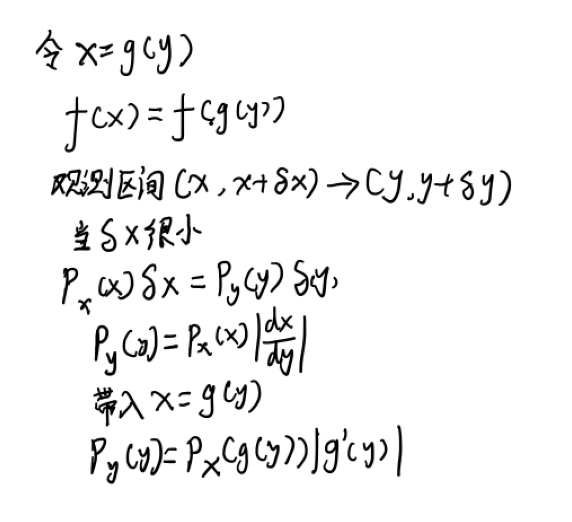

In [21]:
# 概率形式变换
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2形式变化.png')
plt.axis('off')
ax.imshow(d)

定义累计密度分布：<p>
    $$ P(z) = \int_{-\infty}^z p(x)dx \tag{1.28} $$<p>
满足$$ P^\prime(x) = p(x) $$
多变量的时候x是向量，定义是相似的。

加法法则和乘法法则<p>
$p(x) = \int p(x, y) dy \tag{1.31}$ <p>
$p(x, y)= p(y|x)p(x) \tag{1.32}$

## 1.2.2 期望和方差

### 期望就是分布的平均

离散函数的期望：<p>
$$ \mathbb{E}[f] = \sum\limits_xp(x)f(x) \tag{1.33} $$
连续函数的期望:<p>
$$ \mathbb{E}[f] = \int p(x)f(x)dx \tag{1.34} $$
当期望不好直接计算的时候：<p>
    $$ \mathbb{E}[f] \simeq \frac{1}{N}\sum\limits_{n=1}^{N}f(x_n) \tag{1.35} $$
通过采样的方式来估计。<p>
多变量情况下的期望,下标表示对谁求期望<p>
    $$ \mathbb{E}_x[f(x, y)] \tag{1.36} $$
这是一个关于y的函数。<p>
对于一个条件分布，同样有条件期望<p>
    $$ \mathbb{E}[f|y] ＝ \sum\limits_x p(x|y)f(x) \tag{1.37} $$

### 方差就是分布在均值附近的变化性大小

定义为：<p>
    $$ var[f] = \mathbb{E}[(f(x) - \mathbb{E}[f(x)])^2] \tag{1.38} $$
也可以写成<p>
$$ var[f] = \mathbb{E}[f(x)^2] − \mathbb{E}[f(x)]^2 \tag{1.39} $$
所以<p>
    $$ var[x] = \mathbb{E}[x^2] − \mathbb{E}[x]^2 \tag{1.40} $$



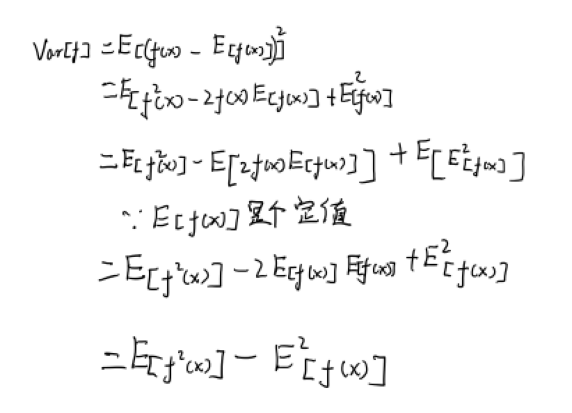

In [4]:
# 方差
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.2方差.png')
plt.axis('off')
ax.imshow(d)

### 协方差表示随机变量x和y的共同变化程度。如果x和y独立，则协方差为0.

$$ \begin{eqnarray} cov[x, y] &=& \mathbb{E}{x,y}[\{x − \mathbb{E}[x]\} \{y − \mathbb{E}[y]\}] \ &=& \mathbb{E}{x,y}[xy] − \mathbb{E}[x]\mathbb{E}[y] \tag{1.41} \end{eqnarray} $$
如果是两个随机向量的情况<p>
    $$ \begin{eqnarray} cov[x, y] &=& \mathbb{E}{x,y}[\{x − \mathbb{E}[x]\} \{y^T − \mathbb{E}[y^T]\}] \ &=& \mathbb{E}{x,y}[xy^T] − \mathbb{E}[x]\mathbb{E}[y^T] \tag{1.42} \end{eqnarray} $$



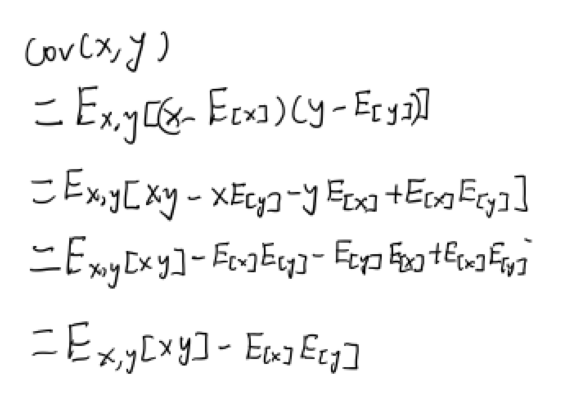

In [5]:
# 协方差
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.2协方差.png')
plt.axis('off')
ax.imshow(d)

## 1.2.3 贝叶斯概率
贝叶斯定理:<p>
    $$ p(w| D) = \frac{p(D|w)p(w)}{p(D)} \tag{1.43} $$

我们可以根据观测到$D$后的后验概率$p(w|D)$来估计$w$的不确定性。贝叶斯定理右侧的量$p(D|w)$由观测到的数据集$D$来估计，可以被看成参数向量$w$的似然函数（likelihood function）。

### 不同的参数向量$w$的情况下，观测到的数据集的可能性为似然函数。
注意似然不表示它是$w$的概率分布，它关于$w $的积分也不（一定）等于1。
$$ \text{posterior} \propto \text{likelihood} × \text{prior} \tag{1.44} $$
分母是归一化因子：<p>
    $$ p(D) = \int p(D|w)P(w)dw \tag{1.45} $$



**频率派：w是固定的参数。最小误差函数就是最大似然估计**<p>
**贝叶斯派：w不是固定的，需要用概率分布表达这种不确定性。**

## 1.2.4 高斯分布
对于一元变量:<p>
$\mathcal{N}\left(x | \mu, \sigma^{2}\right)=\frac{1}{\left(2 \pi \sigma^{2}\right)^{\frac{1}{2}}} \exp \left\{-\frac{1}{2 \sigma^{2}}(x-\mu)^{2}\right\} \tag{1.46} $

满足：<p>
    $$ \mathcal{N}(x|\mu, \sigma^2) > 0 \tag{1.47} $$<p>
    $$ \int_{-\infty}^{\infty} \mathcal{N}(x|\mu, \sigma^2)dx = 1 \tag{1.48} $$



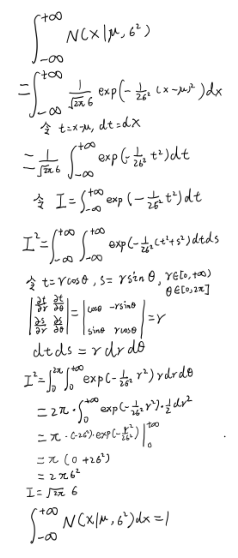

In [3]:
# 归一化
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4归一化.png')
plt.axis('off')
ax.imshow(d)

期望为：<p>
    $$ \mathbb{E}[x] = \int_{-\infty}^{\infty} \mathcal{N}(x|\mu, \sigma^2)xdx = \mu \tag{1.49} $$


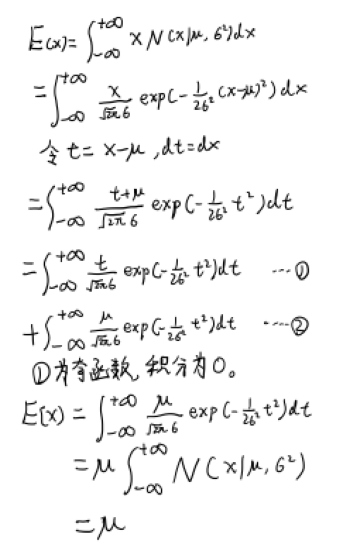

In [5]:
# 期望
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4期望.png')
plt.axis('off')
ax.imshow(d)


$$ \mathbb{E}[x^2] = \int_{-\infty}^{\infty} \mathcal{N}(x|\mu, \sigma^2)x^2dx = \mu^2 + \sigma^2 \tag{1.50} $$

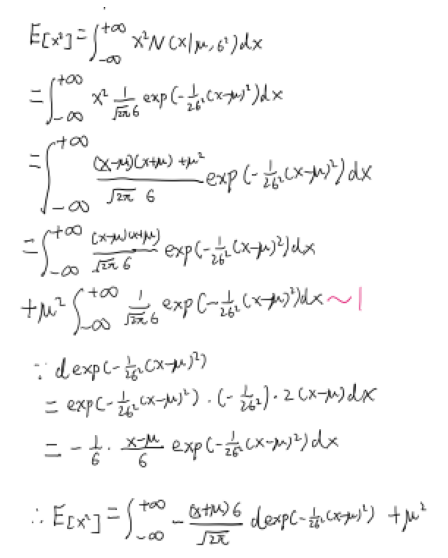

In [7]:
# x2期望
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4期望上.png')
plt.axis('off')
ax.imshow(d)

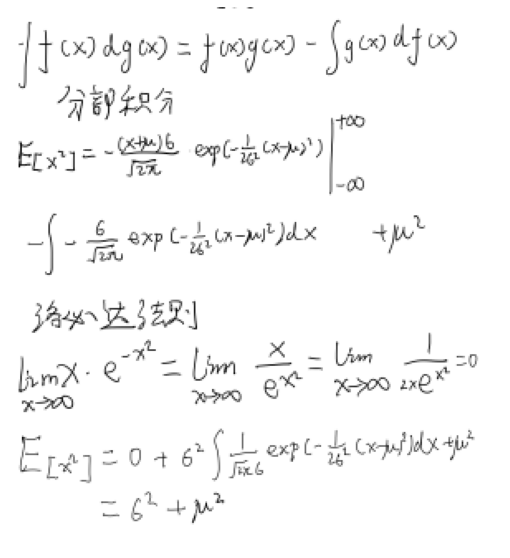

In [8]:
# x2期望
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4期望下.png')
plt.axis('off')
ax.imshow(d)

方差为：<p>
$$ var[x] = \mathbb{E}[x^2] - \mathbb{E}[x]^2 = \sigma^2 \tag{1.51} $$



当x是d维向量：<P>
    $$ \mathcal{N}(x|\mu, \Sigma) = \frac{1}{(2\pi)^{D/2}} \frac{1}{|\Sigma|^{1/2}} exp{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x - \mu)} \tag{1.52} $$

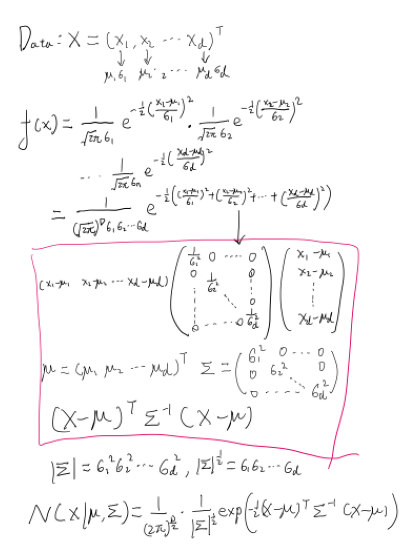

In [9]:
# x2期望
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4高维.png')
plt.axis('off')
ax.imshow(d)

参考资料：<p>
    https://blog.csdn.net/qq_37549266/article/details/95942282<p>
https://www.zhihu.com/question/36339816


当我们进行D次观测。每次取样都是相同的的高斯分布中取样，只是我们不知道期望和方差。独立同分布i.i.d的取样。<p>
数据集的概率为:<p>
    $$ p(X|\mu, \sigma^2) = \prod\limits_{n=1}^{N}N(x_n|\mu, \sigma^2) \tag{1.53} $$

希望可以通过最大似然来求解未知的期望和方差。取对数方便计算<p>
    $$ \ln p(x|\mu, \sigma^2) = -\frac{1}{2\sigma^2}\sum\limits_{n=1}^N(x_n - \mu)^2 - \frac{N}{2}\ln \sigma^2 - \frac{N}{2}\ln(2\pi) \tag{1.54} $$

样本均值:<p>
    $$ \mu_{ML} = \frac{1}{N}\sum\limits_{n=1}^{N}x_n \tag{1.55} $$ 
样本方差:<p>
    $$ \sigma_{ML}^2 = \frac{1}{N}\sum\limits_{n=1}^{N}(x_n - \mu_{ML})^2 \tag{1.56} $$

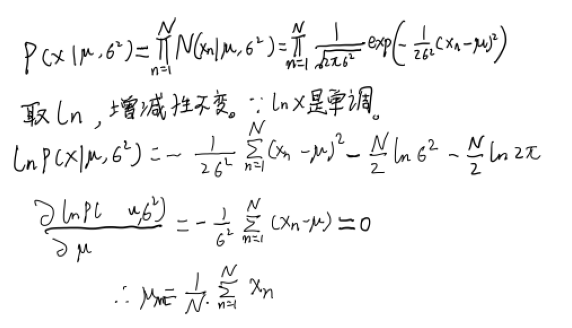

In [3]:
# uml
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4uml.png')
plt.axis('off')
ax.imshow(d)

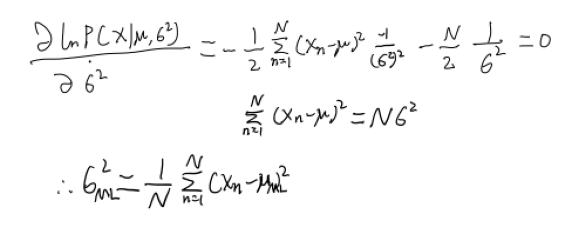

In [4]:
# sigmaml
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4sigml.png')
plt.axis('off')
ax.imshow(d)

当我们用样本的期望和方差来代替原本的期望和方差的时候，期望不会有偏差<p>
    $\mathbb{E}\left[\mu_{M L}\right]=\mu \tag{1.57}$
   
    

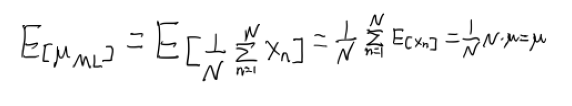

In [5]:
# uml
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4uml期望.png')
plt.axis('off')
ax.imshow(d)

方差会出现偏差。<p>
     $$
\mathbb{E}\left[\sigma_{M L}^{2}\right]=\left(\frac{N-1}{N}\right) \sigma^{2} \tag{1.58}
$$

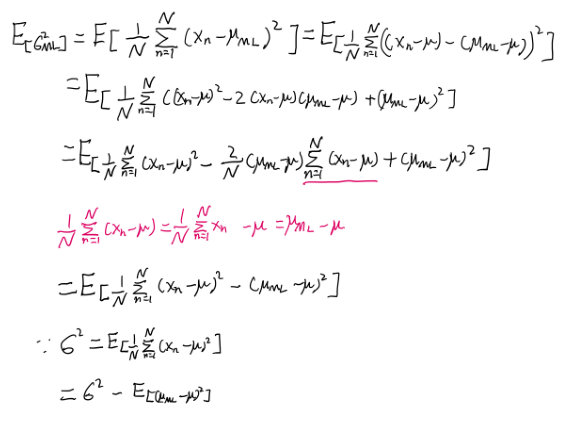

In [6]:
# sigmaml
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4sigml期望上.png')
plt.axis('off')
ax.imshow(d)

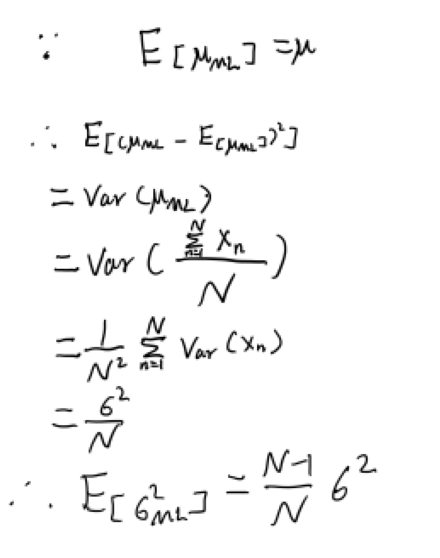

In [8]:
# sigmaml
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4sigml期望下.png')
plt.axis('off')
ax.imshow(d)

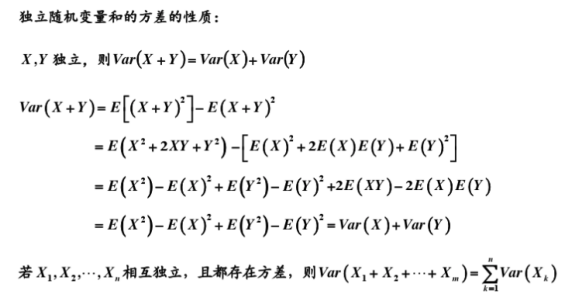

In [9]:
# 方差性质
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.4方差性质.png')
plt.axis('off')
ax.imshow(d)

为了得到无偏估计:<p>
    $$ \widetilde\sigma^2 = \frac{N}{N - 1}\sigma_{ML}^2 = \frac{1}{N - 1}\sum\limits_{n=1}^{N}(x_n - \mu_{ML})^2 \tag{1.59} $$



参考资料：https://www.zhihu.com/question/20099757

## 1.2.5 重新考察曲线拟合
N个输入$ X = (x_1,...,x_N)^T $和输出$ T = (t_1,...,t_N)^T $，在新的输入下求输出。假设t服从$ y(x, w) $相同均值的高斯分布。

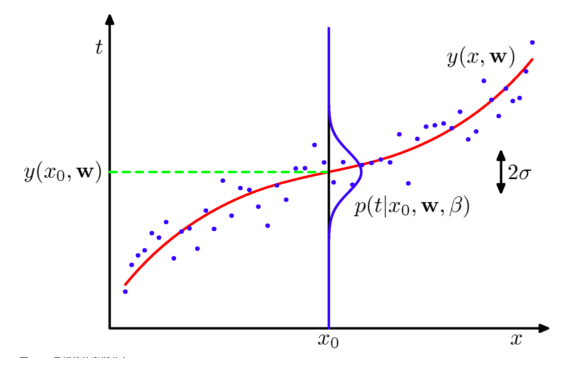

In [2]:
# 方差性质
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.5重回.png')
plt.axis('off')
ax.imshow(d)

$$ p(t|x, w, \beta) = \mathcal{N}(t|y(x, w), \beta^{-1}) \tag{1.60} $$<p>

我们定义的分布的方差的逆为精度-参数$\beta $。

通过最大似然来确定未知参数$ w, \beta $，似然函数为：<p>
$$ p(T|X, w, \beta) = \prod\limits_{n=1}^{N}\mathcal{N}(t_n|y(x_n, w), \beta^{-1}) \tag{1.61} $$<p>
取对数<p>
$$ \ln p(T|X, w, \beta) = -\frac{\beta}{2}\sum\limits_{n=1}^{N}\{y(x_n, w) - t_n\}^2 + \frac{N}{2}\ln{\beta} - \frac{N}{2}\ln{(2\pi)} \tag{1.62} $$<p>
   多项式系数的最大似然解，记作$ w_{ML} $。就是最小化误差函数。而精度等于：<p>
    $$ \frac{1}{\beta_{ML}} = \frac{1}{N}\sum\limits_{n=1}^{N}{y(x_x, w_{ML}) - t_n}^2 \tag{1.63} $$<p>
带入1.60就是结果<p>
$$ p(t|x, w_{ML}, \beta_{ML}) = \mathcal{N}(t|y(x, w_{ML}), \beta_{ML}^{-1}) \tag{1.64} $$



引入w的先验:<p>
    $$
p(\boldsymbol{w} | \alpha)=\mathcal{N}\left(\boldsymbol{w} | \mathbf{0}, \alpha^{-1} \boldsymbol{I}\right)=\left(\frac{\alpha}{2 \pi}\right)^{\frac{M+1}{2}} \exp \left\{-\frac{\alpha}{2} \boldsymbol{w}^{T} \boldsymbol{w}\right\} \tag{1.65}
$$<p>
这里有超参数$ \alpha $控制先验分布。利用贝叶斯定理可以得到。    
    $$ p(w|X, T, \alpha, \beta) \propto p(T|X, w, \beta)p(w|\alpha) \tag{1.66} $$<p>
最大后验MAP就是最大化1.66。取-ln我们可以得到最大后验等价于下面的式子<p>
    $$ \frac{\beta}{2}\sum\limits_{n=1}^{N}\{y(x_n, w) - t_n\}^2 + \frac{\alpha}{2}w^Tw \tag{1.67} $$
就是有正则化项的误差函数。

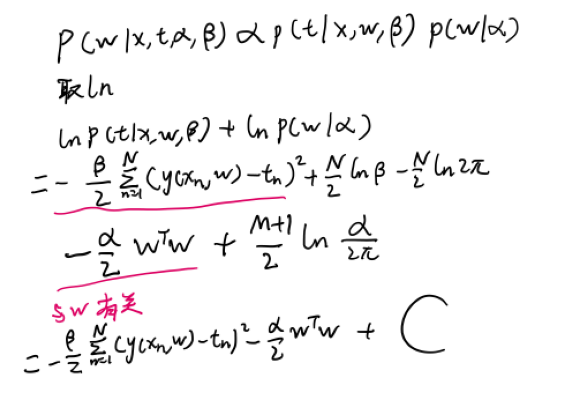

In [3]:
# 方差性质
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.5MAP.png')
plt.axis('off')
ax.imshow(d)

## 1.2.6 贝叶斯曲线拟合
上一节我们还是引入了w，并对w进行估计，这不是完全的贝叶斯方法。这节我们对w积分，这是贝叶斯方法的核心。<p>
    我们希望的是应用训练集合(X,T)，在已知新的数据x的情况下得到目标值t的概率分布:<p>
        $$ p(t|x, X, T) = \int p(t|x, w)p(w|X, T)dw \tag{1.68} $$<p>

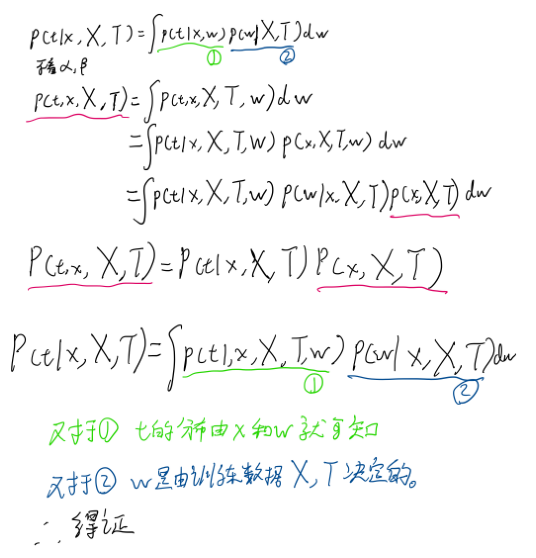

In [2]:
# 贝叶斯
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.6贝叶斯.png')
plt.axis('off')
ax.imshow(d)

其实这个积分也是可以求解的，解为：<p>
    $$ p(t|x, X, T) = \mathcal{N}(t|m(x), s^2(x)) \tag{1.69} $$

$$
m(x)=\beta \phi(x)^{T} S \sum_{n=1}^{N} \phi\left(x_{n}\right) t_{n} \tag{1.70}
$$<p>
    $$
s^{2}(x)=\beta^{-1}+\phi(x)^{T} \boldsymbol{S} \phi(x) \tag{1.71}
$$<p>
    $$ S^{-1} = \alpha I + \beta\sum\limits_{n=1}^N\phi(x_n)\phi(x)^T \tag{1.72} $$<p>
其中$ I $是单位矩阵，定义向量$\phi(x) $为$ \phi_i(x) = x^i, i = 0,...,M $。




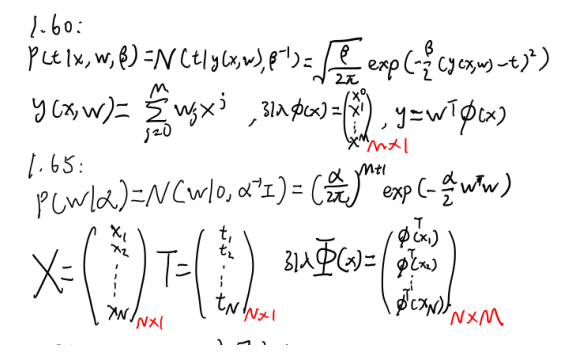

In [3]:
# preparation
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.6preparation.png')
plt.axis('off')
ax.imshow(d)

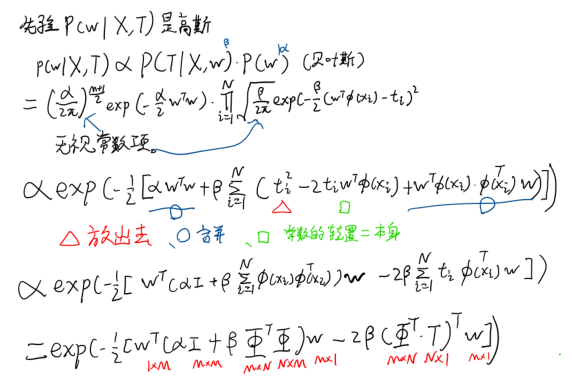

In [5]:
# up
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.6up.png')
plt.axis('off')
ax.imshow(d)

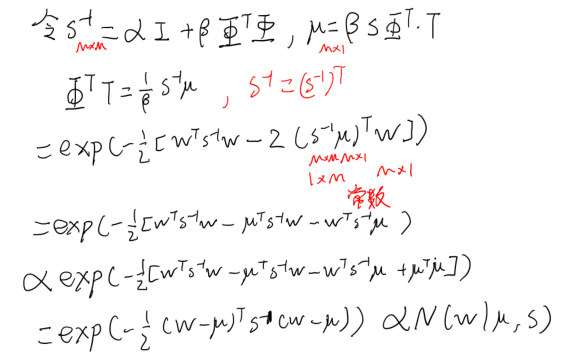

In [6]:
# down
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2.6down.png')
plt.axis('off')
ax.imshow(d)

剩余证明：https://www.cnblogs.com/wacc/p/5495448.html <p>
参考资料：https://qiita.com/gucchi0403/items/bfffd2586272a4c05a73

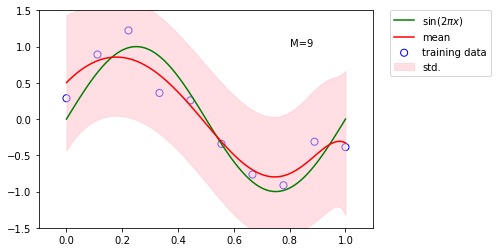

In [10]:
# 贝叶斯曲线拟合
model = BayesianRegression(alpha=2e-3, beta=2)
model.fit(X_train, y_train)

y, y_err = model.predict(X_test, return_std=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y, c="r", label="mean")
plt.fill_between(x_test, y - y_err, y + y_err, color="pink", label="std.", alpha=0.5)
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.annotate("M=9", xy=(0.8, 1))
plt.legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.)
plt.show()

# 1.3 模型选择
我们训练出了很多模型，因为可能发生过拟合，我们需要正则化。也需要一个判断泛化性能好坏的标准。一般用一个未参与训练的测试集，进行交叉验证。

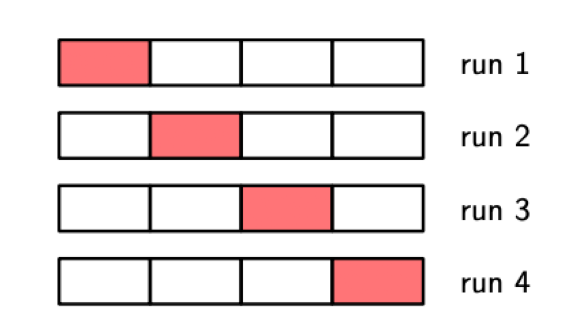

In [12]:
# 交叉验证
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.3交叉验证.png')
plt.axis('off')
ax.imshow(d)

对所有模型的优劣求平均。如果留出的数据只有一个就是留一验证。但缺点：<p>
1.训练次数随着分割的变细而增加，时间成本增加。<p>
2.参数太多，参数的组合甚至是指数型增加，我们如何选择测试集。<p>

### 我们模型是由训练数据而决定的，不是参数的选择而决定。

赤池信息准则AIC akaike information criterion：<p>
    $$ \ln p(D|w_{ML}) - M \tag{1.73} $$

这里的$ p(D|w_{ML}) $是最合适的对数似然函数，$ M $是模型中的可调节参数。之后还有BIC。

# 1.4维度灾难
高维数据数据难区分。

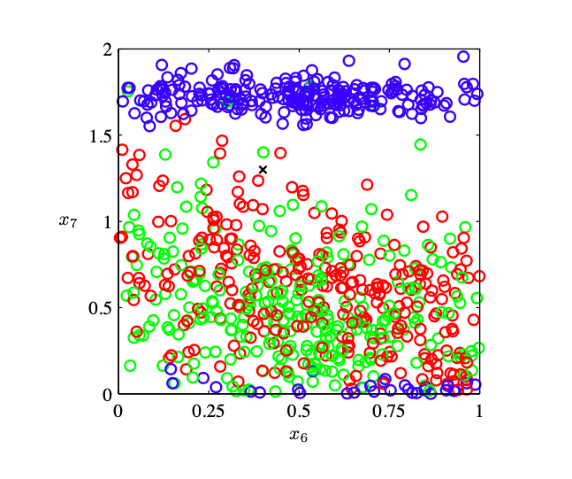

In [14]:
# 太多参数
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.3神奇数据.png')
plt.axis('off')
ax.imshow(d)

一种解法就是划分成小格子，格子里多的点就是这个区域的点。但划分个数随参数的维度增加激增。

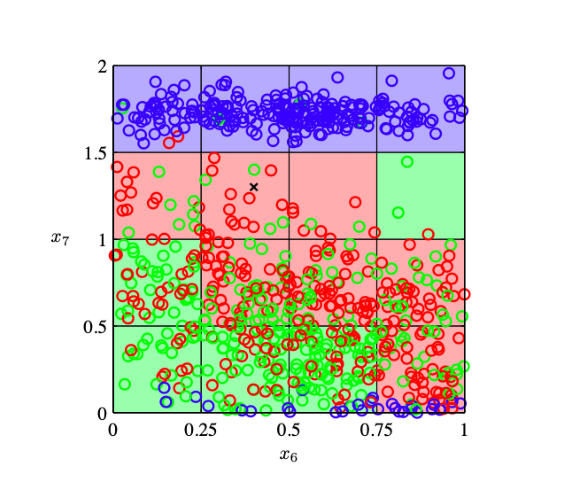

In [2]:
# 小格子
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.4小格子.png')
plt.axis('off')
ax.imshow(d)

推广到曲线拟合上。我们有D个输入变量，一个三阶多项式系数随着D的增加是幂增加。<p>
    $$ y(x, w) = w_0 + \sum_{i=1}^Dw_ix_i + \sum_{i=1}^D\sum_{j=1}^Dw_{ij}x_ix_j + \sum_{i=1}^D\sum_{j=1}^D\sum_{k=1}^Dw_{ijk}x_ix_jx_k \tag{1.74} $$

这里是系数的个数正比于$ D^3 $。M阶多项式就正比于$ D^M $了。

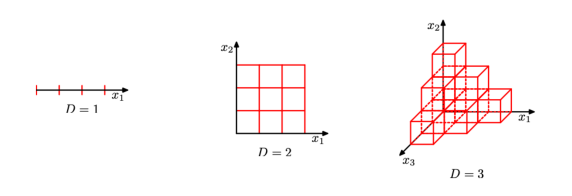

In [3]:
# 演变
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.4小格子演变.png')
plt.axis('off')
ax.imshow(d)

高维到底会产生什么效果。比方说一个D维空间的半径r=1的球体。$ r = 1 − \epsilon $和半径$r = 1 $之间的部分占球的总体积的百分比是多少。<p>
    $$ V_D(r) = K_Dr^D \tag{1.75} $$<p>
    $$ \frac{V_D(1) - V_D(1-\epsilon)}{V_D(1)} = 1 - (1 - \epsilon)^D \tag{1.76} $$

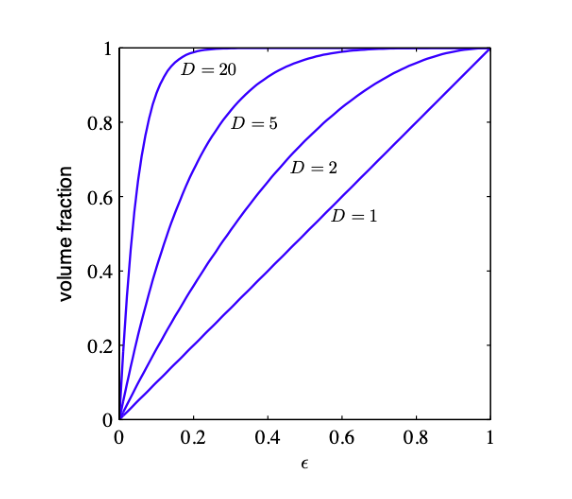

In [5]:
# 太多参数
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.4高维球.png')
plt.axis('off')
ax.imshow(d)

因此，在高维空间中，一个球体的大部分体积都聚集在表面附近的薄球壳上!

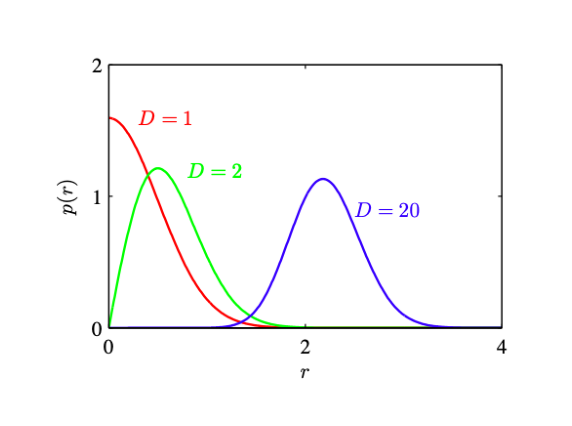

In [8]:
# 高维球体积分布
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.4高维球的体积.png')
plt.axis('off')
ax.imshow(d)

不是所有在低维空间的直觉都可以推广到 高维空间。

即便如此，我们依然要使用高维度的数据。真实数据两个特点：1.目标受限在较低有效维度的空间》输入复杂的图片，但目标只是区分简单的任务。2.局部比较光滑，不会突变》空隙部分用插值估计。

## 1.5决策论
医学诊断，我们给病人拍了X光片，来诊断他是否得了癌症。<p>
输入向量$ x $是X光片的像素的灰度值集合，输出变量$ t $表示病人患有癌症，记作类$ C_1 $或者不患癌症，记作类$ C_2 $。实际中，我们可能二元变量（如：$ t = 0 $来表示$ C_1 $类，$t = 1 $来表示$ C_2 $类）来表示。<p>

希望得到$ p(C_k|x) $。使用贝叶斯方法这些概率可以表示为：

$ p(C_k|x) = \frac{p(x|C_k)p(C_k)}{p(x)} \tag{1.77} $

$ p(C_1) $表示在拍X光片前病人患有癌症的概率，同样的，$ p(C_1|x) $表示获得X光片信息后使用贝叶斯定理修正的后验概率。

### 1.5.1 最小化错误分类率
$$ \begin{eqnarray} p(mistake) &=& p(x \in R_1, C_2) + p(x \in R_2, C_1) \ &=& \int_{R_1} p(x, C_2)dx + \int_{R_2} p(x, C_1)dx \tag{1.78} \end{eqnarray} $$<p>
对于$ x $如果$p(x, C_1) > p(x, C_2) $，那么就把$ x $分到类$ C_1 $中。<p>


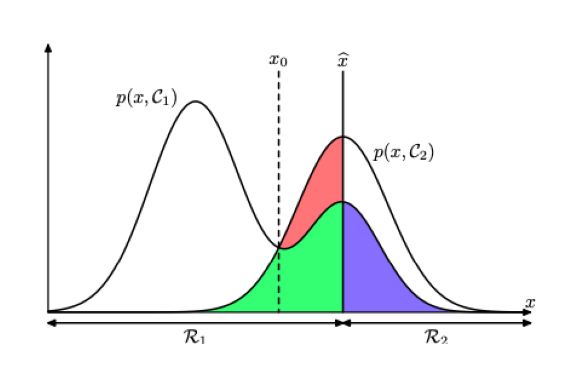

In [2]:
# 最小错误
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.5.1最小错误.png')
plt.axis('off')
ax.imshow(d)

对于更一般的K 类的情形,计算正确率会更简单。$$ \begin{eqnarray} p(correct) &=& \sum\limits_{k=1}^K p(x \in R_k, C_k) \ &=& \sum\limits_{k=1}^K\int_{R_k}p(x, C_k)dx \tag{1.79} \end{eqnarray} $$

### 1.5.2 最小化期望损失
真实分类是$C_k$,实际分类是$C_j$.定义损失矩阵：

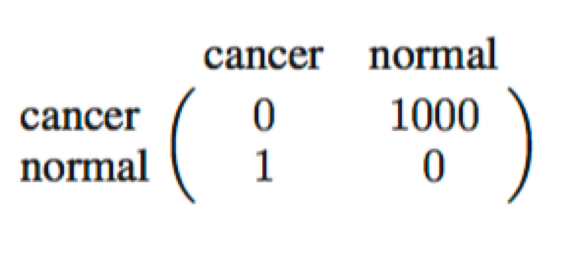

In [4]:
# 损失矩阵
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.5.2损失矩阵.png')
plt.axis('off')
ax.imshow(d)

损失函数变为$$ \mathbb{E}[L] = \sum\limits_k\sum\limits_j\int_{R_j} L_{kj}p(x, C_k)dx \tag{1.80} $$

消去共同因子P(x)，根据决策规则就是对于每个新的x，使它分到能使得下式取得最小值的j类。
$$ \sum\limits_kL_{kj}p(C_k|x) $$



### 1.5.3拒绝选项
引入$\theta$,低于$\theta$的后验概率$ p(C_k|x) $进行进一步检测或交给专家。

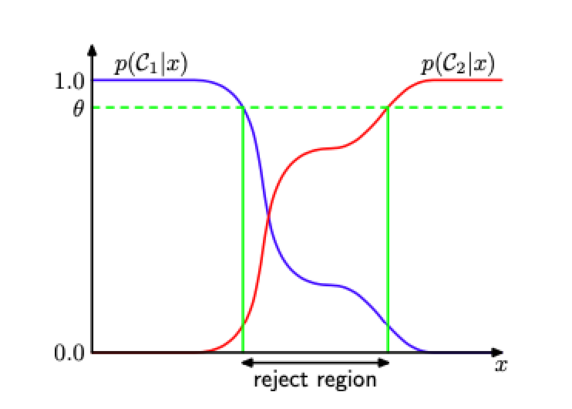

In [5]:
# theta
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.5.3theta.png')
plt.axis('off')
ax.imshow(d)